In [ ]:
! pip install pyarrow matplotlib pandas polars seaborn psutil numpy

## Librerías

In [104]:
import os
import time
import psutil
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
DATA_PATH = "yellow_tripdata_2015-01.csv"

## Funciones de ayuda

In [70]:
def get_memory_mb() -> float:
    """
    Retorna la memoria residente (RSS) del proceso actual en MB.
    """
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)


def benchmark_operation(library: str,
                        operation_name: str,
                        func,
                        results_list: list):
    print(f"\n[{library.upper()}] Ejecutando operación: {operation_name}")
    mem_before = get_memory_mb()
    t0 = time.perf_counter()

    result = func()

    elapsed = time.perf_counter() - t0
    mem_after = get_memory_mb()
    delta_mem = mem_after - mem_before

    print(f"Tiempo: {elapsed:.4f} s | ΔMemoria: {delta_mem:.2f} MB")

    results_list.append({
        "library": library,
        "operation": operation_name,
        "time_sec": elapsed,
        "delta_mem_MB": delta_mem
    })

    return result

# Operaciones

## Lectura de dataset

### Pandas

In [71]:
def load_pandas_df(path: str) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"]
    )
    return df

### Polars

In [72]:
def load_polars_df(path: str) -> pl.DataFrame:
    df = pl.read_csv(
        path,
        try_parse_dates=True
    )
    return df

## 1. Filtro de viajes largos

### Pandas

In [73]:
def op1_pandas_long_trips_count(df: pd.DataFrame):
    """
    Contar viajes con distancia > 10 millas.
    """
    return df[df["trip_distance"] > 10].shape[0]

### Polars

In [74]:
def op1_polars_long_trips_count(df: pl.DataFrame):
    return df.filter(pl.col("trip_distance") > 10).height

## 2. Promedio de total_amount por passenger_count

### Pandas

In [75]:
def op2_pandas_mean_total_by_passengers(df: pd.DataFrame):
    return (
        df.groupby("passenger_count", as_index=False)["total_amount"]
        .mean()
    )

### Polars

In [76]:
def op2_polars_mean_total_by_passengers(df: pl.DataFrame):
    return (
        df.group_by("passenger_count")
        .agg(pl.col("total_amount").mean().alias("total_amount_mean"))
    )

## 3. Promedio de fare_amount por hora de pickup

### Pandas

In [77]:
def op3_pandas_mean_fare_by_hour(df: pd.DataFrame):
    tmp = df.copy()
    tmp["pickup_hour"] = tmp["tpep_pickup_datetime"].dt.hour
    return (
        tmp.groupby("pickup_hour", as_index=False)["fare_amount"]
        .mean()
    )

### Polars

In [78]:
def op3_polars_mean_fare_by_hour(df: pl.DataFrame):
    # Asegurar que la columna sea Datetime si no lo es
    tmp = df.with_columns(
        pl.col("tpep_pickup_datetime").cast(pl.Datetime, strict=False)
    ).with_columns(
        pl.col("tpep_pickup_datetime").dt.hour().alias("pickup_hour")
    )
    return (
        tmp.group_by("pickup_hour")
        .agg(pl.col("fare_amount").mean().alias("fare_amount_mean"))
    )

## 4. Top 1000 viajes por tip_amount

### Pandas

In [79]:
def op4_pandas_top_tips(df: pd.DataFrame):
    return (
        df.nlargest(1000, "tip_amount")
        [["tpep_pickup_datetime", "trip_distance", "fare_amount", "tip_amount"]]
    )

### Polars

In [80]:
def op4_polars_top_tips(df: pl.DataFrame):
    return (
        df.sort("tip_amount", descending=True)
        .select(["tpep_pickup_datetime", "trip_distance", "fare_amount", "tip_amount"])
        .head(1000)
    )

## 5. Conteo por tipo de pago (value_counts)

### Pandas

In [81]:
def op5_pandas_payment_counts(df: pd.DataFrame):
    return df["payment_type"].value_counts()

### Polars

In [82]:
def op5_polars_payment_counts(df: pl.DataFrame):
    return (
        df.group_by("payment_type")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )

## 6. Promedio de distancia por fecha de pickup

### Pandas

In [83]:
def op6_pandas_mean_distance_by_date(df: pd.DataFrame):
    tmp = df.copy()
    tmp["pickup_date"] = tmp["tpep_pickup_datetime"].dt.date
    return (
        tmp.groupby("pickup_date", as_index=False)["trip_distance"]
        .mean()
    )

### Polars

In [84]:
def op6_polars_mean_distance_by_date(df: pl.DataFrame):
    tmp = df.with_columns(
        pl.col("tpep_pickup_datetime").cast(pl.Datetime, strict=False)
    ).with_columns(
        pl.col("tpep_pickup_datetime").dt.date().alias("pickup_date")
    )
    return (
        tmp.group_by("pickup_date")
        .agg(pl.col("trip_distance").mean().alias("trip_distance_mean"))
    )

## 7. Correlación trip_distance vs total_amount

### Pandas

In [85]:
def op7_pandas_corr_distance_total(df: pd.DataFrame):
    return df["trip_distance"].corr(df["total_amount"])

### Polars

In [86]:
def op7_polars_corr_distance_total(df: pl.DataFrame):
    # Polars tiene pl.corr
    return df.select(
        pl.corr(pl.col("trip_distance"), pl.col("total_amount")).alias("corr")
    )

## 8. Percentil 95 de total_amount

### Pandas

In [87]:
def op8_pandas_quantile_total(df: pd.DataFrame):
    return df["total_amount"].quantile(0.95)

### Polars

In [88]:
def op8_polars_quantile_total(df: pl.DataFrame):
    return df.select(
        pl.col("total_amount").quantile(0.95).alias("q95_total_amount")
    )


## 9. Filtro coordenadas aprox. Manhattan, conteo

### Pandas

In [89]:
def op9_pandas_manhattan_bbox_count(df: pd.DataFrame):
    """
    BBox aproximado de Manhattan:
        lat: 40.70 a 40.88
        lon: -74.02 a -73.90
    """
    cond = (
        (df["pickup_latitude"].between(40.70, 40.88)) &
        (df["pickup_longitude"].between(-74.02, -73.90))
    )
    return df[cond].shape[0]

### Polars

In [90]:
def op9_polars_manhattan_bbox_count(df: pl.DataFrame):
    cond = (
        (pl.col("pickup_latitude").is_between(40.70, 40.88)) &
        (pl.col("pickup_longitude").is_between(-74.02, -73.90))
    )
    return df.filter(cond).height

## 10. Agregación por VendorID y RateCodeID

### Pandas

In [91]:
def op10_pandas_vendor_rate_agg(df: pd.DataFrame):
    return (
        df.groupby(["VendorID", "RateCodeID"], as_index=False)
        .agg(
            mean_distance=("trip_distance", "mean"),
            mean_total=("total_amount", "mean"),
            trips=("VendorID", "count")
        )
    )

### Polars

In [92]:
def op10_polars_vendor_rate_agg(df: pl.DataFrame):
    return (
        df.group_by(["VendorID", "RateCodeID"])
        .agg([
            pl.col("trip_distance").mean().alias("mean_distance"),
            pl.col("total_amount").mean().alias("mean_total"),
            pl.len().alias("trips")
        ])
    )

# Benchmarking

In [94]:
results = []
# 4.1 Carga de datos
pandas_df = benchmark_operation(
    library="pandas",
    operation_name="read_csv",
    func=lambda: load_pandas_df(DATA_PATH),
    results_list=results
)

polars_df = benchmark_operation(
    library="polars",
    operation_name="read_csv",
    func=lambda: load_polars_df(DATA_PATH),
    results_list=results
)

# 4.2 Benchmark de las 10 operaciones

# --- Lista de operaciones pandas ---
pandas_ops = [
    ("op1_long_trips_count", lambda: op1_pandas_long_trips_count(pandas_df)),
    ("op2_mean_total_by_passengers", lambda: op2_pandas_mean_total_by_passengers(pandas_df)),
    ("op3_mean_fare_by_hour", lambda: op3_pandas_mean_fare_by_hour(pandas_df)),
    ("op4_top_tips", lambda: op4_pandas_top_tips(pandas_df)),
    ("op5_payment_counts", lambda: op5_pandas_payment_counts(pandas_df)),
    ("op6_mean_distance_by_date", lambda: op6_pandas_mean_distance_by_date(pandas_df)),
    ("op7_corr_distance_total", lambda: op7_pandas_corr_distance_total(pandas_df)),
    ("op8_quantile_total", lambda: op8_pandas_quantile_total(pandas_df)),
    ("op9_manhattan_bbox_count", lambda: op9_pandas_manhattan_bbox_count(pandas_df)),
    ("op10_vendor_rate_agg", lambda: op10_pandas_vendor_rate_agg(pandas_df)),
]

# --- Lista de operaciones Polars ---
polars_ops = [
    ("op1_long_trips_count", lambda: op1_polars_long_trips_count(polars_df)),
    ("op2_mean_total_by_passengers", lambda: op2_polars_mean_total_by_passengers(polars_df)),
    ("op3_mean_fare_by_hour", lambda: op3_polars_mean_fare_by_hour(polars_df)),
    ("op4_top_tips", lambda: op4_polars_top_tips(polars_df)),
    ("op5_payment_counts", lambda: op5_polars_payment_counts(polars_df)),
    ("op6_mean_distance_by_date", lambda: op6_polars_mean_distance_by_date(polars_df)),
    ("op7_corr_distance_total", lambda: op7_polars_corr_distance_total(polars_df)),
    ("op8_quantile_total", lambda: op8_polars_quantile_total(polars_df)),
    ("op9_manhattan_bbox_count", lambda: op9_polars_manhattan_bbox_count(polars_df)),
    ("op10_vendor_rate_agg", lambda: op10_polars_vendor_rate_agg(polars_df)),
]

# Ejecutar operaciones pandas
for op_name, func in pandas_ops:
    _ = benchmark_operation(
        library="pandas",
        operation_name=op_name,
        func=func,
        results_list=results
    )

# Ejecutar operaciones Polars
for op_name, func in polars_ops:
    _ = benchmark_operation(
        library="polars",
        operation_name=op_name,
        func=func,
        results_list=results
    )


[PANDAS] Ejecutando operación: read_csv
Tiempo: 31.1341 s | ΔMemoria: 390.20 MB

[POLARS] Ejecutando operación: read_csv
Tiempo: 4.2468 s | ΔMemoria: -302.45 MB

[PANDAS] Ejecutando operación: op1_long_trips_count
Tiempo: 0.5288 s | ΔMemoria: 1845.44 MB

[PANDAS] Ejecutando operación: op2_mean_total_by_passengers
Tiempo: 0.1888 s | ΔMemoria: 40.31 MB

[PANDAS] Ejecutando operación: op3_mean_fare_by_hour
Tiempo: 1.0343 s | ΔMemoria: -714.41 MB

[PANDAS] Ejecutando operación: op4_top_tips
Tiempo: 1.6838 s | ΔMemoria: -709.55 MB

[PANDAS] Ejecutando operación: op5_payment_counts
Tiempo: 0.0540 s | ΔMemoria: 60.72 MB

[PANDAS] Ejecutando operación: op6_mean_distance_by_date
Tiempo: 3.6298 s | ΔMemoria: -246.42 MB

[PANDAS] Ejecutando operación: op7_corr_distance_total
Tiempo: 0.1336 s | ΔMemoria: 222.88 MB

[PANDAS] Ejecutando operación: op8_quantile_total
Tiempo: 0.1457 s | ΔMemoria: 3.33 MB

[PANDAS] Ejecutando operación: op9_manhattan_bbox_count
Tiempo: 1.1323 s | ΔMemoria: 526.02 MB



In [96]:
results_df = pd.DataFrame(results)
print("\n--- RESULTADOS DEL BENCHMARK (pandas vs Polars) ---")
display(results_df)  # en notebook se ve bonito

# Tabla pivote para comparar por operación
pivot_time = results_df.pivot(index="operation", columns="library", values="time_sec")
pivot_mem = results_df.pivot(index="operation", columns="library", values="delta_mem_MB")

print("\n--- Comparación de tiempo (s) por operación ---")
display(pivot_time)

print("\n--- Comparación de delta de memoria (MB) por operación---")
display(pivot_mem)


--- RESULTADOS DEL BENCHMARK (pandas vs Polars) ---


,library,operation,time_sec,delta_mem_MB
0,pandas,read_csv,31.134097,390.203125
1,polars,read_csv,4.246840,-302.453125
2,pandas,op1_long_trips_count,0.528808,1845.437500
3,pandas,op2_mean_total_by_passengers,0.188769,40.312500
4,pandas,op3_mean_fare_by_hour,1.034256,-714.406250
5,pandas,op4_top_tips,1.683801,-709.546875
6,pandas,op5_payment_counts,0.053963,60.718750
7,pandas,op6_mean_distance_by_date,3.629776,-246.421875
8,pandas,op7_corr_distance_total,0.133573,222.875000
9,pandas,op8_quantile_total,0.145728,3.328125



--- Comparación de tiempo (s) por operación ---


library,pandas,polars
operation,,
op10_vendor_rate_agg,0.533546,1.629848
op1_long_trips_count,0.528808,0.433272
op2_mean_total_by_passengers,0.188769,0.055504
op3_mean_fare_by_hour,1.034256,0.071325
op4_top_tips,1.683801,2.635603
op5_payment_counts,0.053963,0.049474
op6_mean_distance_by_date,3.629776,0.138206
op7_corr_distance_total,0.133573,0.043523
op8_quantile_total,0.145728,0.060855



--- Comparación de delta de memoria (MB) por operación---


library,pandas,polars
operation,,
op10_vendor_rate_agg,463.828125,-1749.281250
op1_long_trips_count,1845.437500,1250.875000
op2_mean_total_by_passengers,40.312500,-67.484375
op3_mean_fare_by_hour,-714.406250,-14.765625
op4_top_tips,-709.546875,-2859.343750
op5_payment_counts,60.718750,128.750000
op6_mean_distance_by_date,-246.421875,267.343750
op7_corr_distance_total,222.875000,100.171875
op8_quantile_total,3.328125,0.375000


In [97]:
# Guardar a CSV para análisis posterior
results_df.to_csv("benchmark_pandas_vs_polars_results.csv", index=False)
pivot_time.to_csv("benchmark_pandas_vs_polars_time_pivot.csv")
pivot_mem.to_csv("benchmark_pandas_vs_polars_memory_pivot.csv")

# Gráficos

In [105]:
ordered_ops = sorted(pivot_time.index.tolist())
pivot_time = pivot_time.loc[ordered_ops]
pivot_mem = pivot_mem.loc[ordered_ops]

sns.set(style="whitegrid", context="notebook")

# Crear copia del dataframe con colores personalizados
plot_df = results_df.copy()

# Asignar color según librería
plot_df["color"] = plot_df["library"].map({
    "pandas": "#e63946",   # rojo
    "polars": "#457b9d"    # azul
})

# Orden lógico de operaciones
ordered_ops = sorted(plot_df["operation"].unique())

## Comparación de tiempos (segundos)

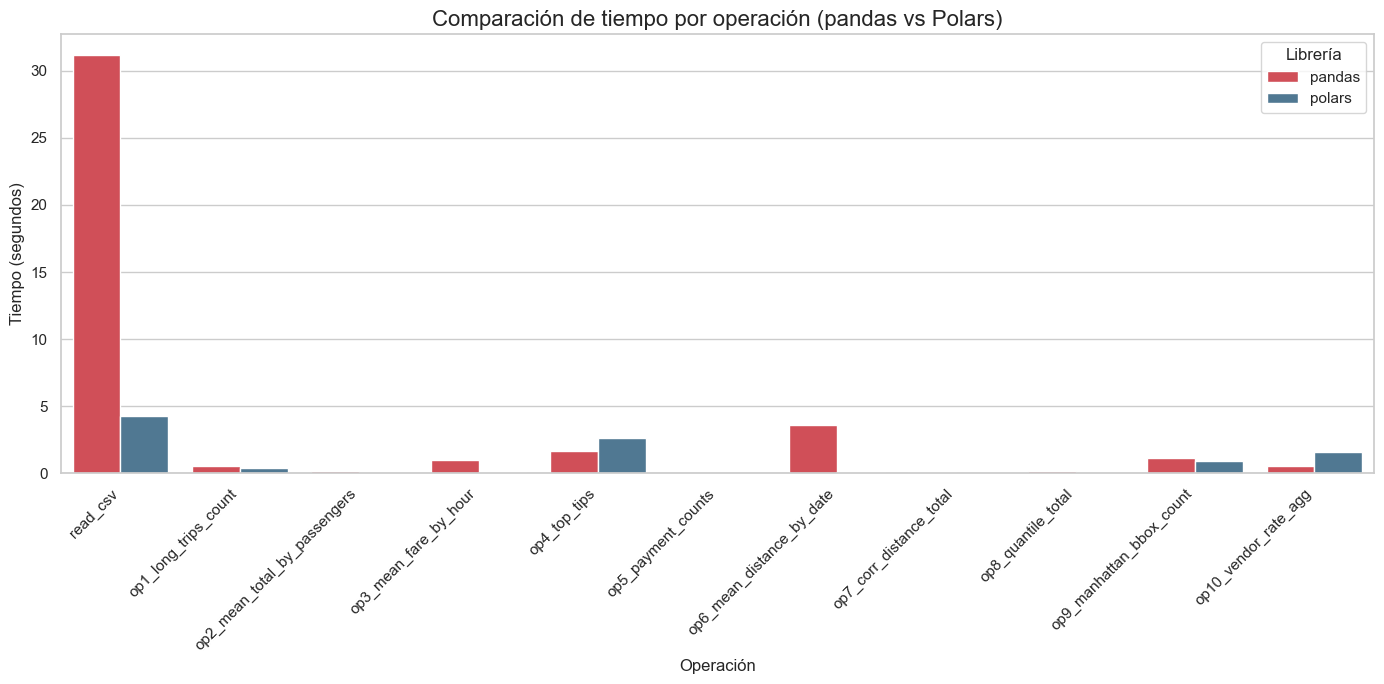

In [106]:
plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x="operation",
    y="time_sec",
    hue="library",
    palette={"pandas": "#e63946", "polars": "#457b9d"},
)

plt.title("Comparación de tiempo por operación (pandas vs Polars)", fontsize=16)
plt.xlabel("Operación", fontsize=12)
plt.ylabel("Tiempo (segundos)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Librería")
plt.tight_layout()
plt.show()

## Comparación de Δ memoria (MB)

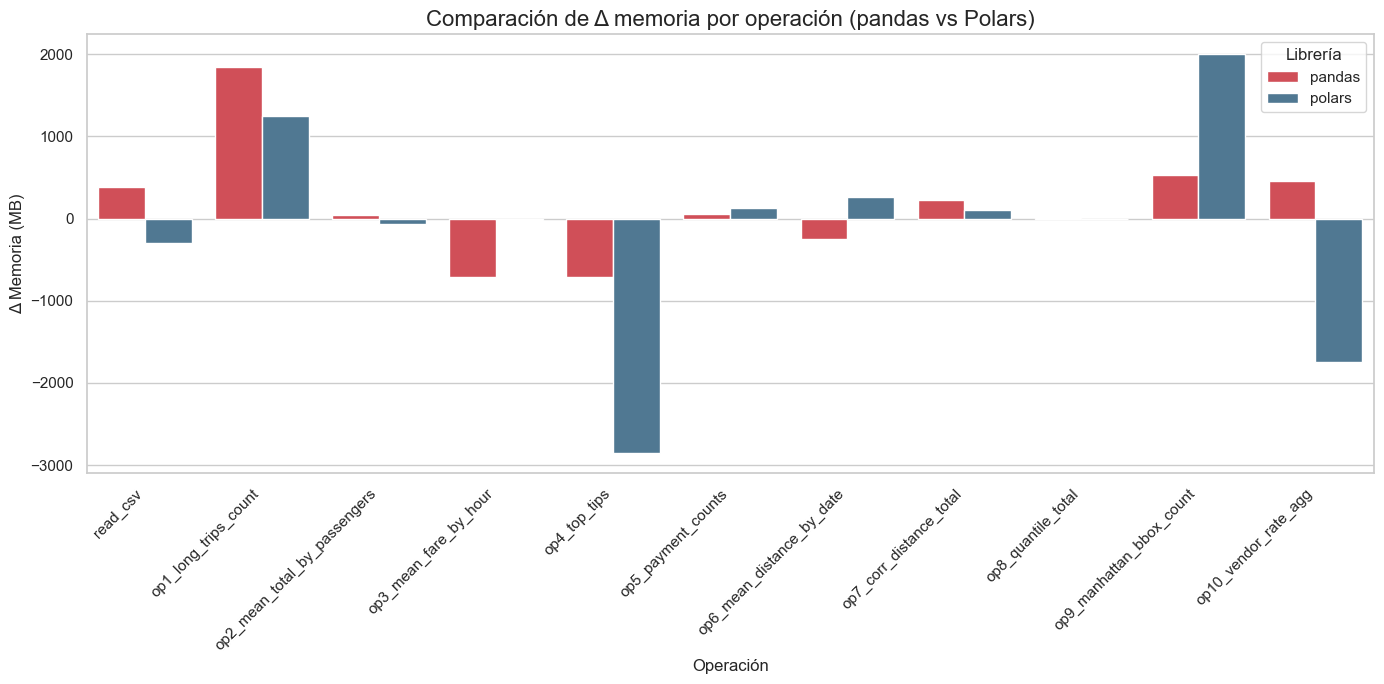

In [107]:
plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x="operation",
    y="delta_mem_MB",
    hue="library",
    palette={"pandas": "#e63946", "polars": "#457b9d"},
)

plt.title("Comparación de Δ memoria por operación (pandas vs Polars)", fontsize=16)
plt.xlabel("Operación", fontsize=12)
plt.ylabel("Δ Memoria (MB)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Librería")
plt.tight_layout()
plt.show()
